from https://www.kaggle.com/c/ieee-fraud-detection 

Transaction Table *

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Identity Table *

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* Categorical Features:
* DeviceType
* DeviceInfo
* id_12 - id_38



In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import gc
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
plt.rcParams['figure.figsize'] = (16,12)
skip_start = False
speed = False
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [3]:
if not skip_start:
    train_identity = pd.read_csv('data/ieee-fraud-detection/train_identity.csv')
    train_transaction = pd.read_csv('data/ieee-fraud-detection/train_transaction.csv')

In [4]:
if not skip_start:
    train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
    print("missing:", dict(train.isna().mean()))
#     train = train.drop(columns=[x for x in train.columns if x.startswith("V")])
    train.shape

missing: {'TransactionID': 0.0, 'isFraud': 0.0, 'TransactionDT': 0.0, 'TransactionAmt': 0.0, 'ProductCD': 0.0, 'card1': 0.0, 'card2': 0.015126833068039422, 'card3': 0.0026501168422122124, 'card4': 0.00267043722694483, 'card5': 0.007212043214684865, 'card6': 0.0026602770345785214, 'addr1': 0.1112642666034477, 'addr2': 0.1112642666034477, 'dist1': 0.596523520845328, 'dist2': 0.9362837403054831, 'P_emaildomain': 0.1599485216920107, 'R_emaildomain': 0.7675161716395164, 'C1': 0.0, 'C2': 0.0, 'C3': 0.0, 'C4': 0.0, 'C5': 0.0, 'C6': 0.0, 'C7': 0.0, 'C8': 0.0, 'C9': 0.0, 'C10': 0.0, 'C11': 0.0, 'C12': 0.0, 'C13': 0.0, 'C14': 0.0, 'D1': 0.0021488806854743116, 'D2': 0.4754919226470688, 'D3': 0.44514850814508755, 'D4': 0.2860466691502693, 'D5': 0.524674027161581, 'D6': 0.8760676668811597, 'D7': 0.9340992989467267, 'D8': 0.8731229044603245, 'D9': 0.8731229044603245, 'D10': 0.1287330240119213, 'D11': 0.47293494090154775, 'D12': 0.8904104717715988, 'D13': 0.8950926270870728, 'D14': 0.8946946862193924

In [5]:
if not skip_start:
    del train_identity, train_transaction
    gc.collect()


In [6]:
if not skip_start:
    # move isFraud to end
    isFraud = train['isFraud']
    train.drop(labels=['isFraud'], axis=1, inplace = True)
    train['isFraud'] = isFraud
    del isFraud

    # print amount of each
    frauds = train.shape[0]
    yes = train['isFraud'].sum()
    no = frauds - yes
    print('{} frauds\n'.format(frauds))
    print('{} yes \n{} no\n'.format(yes,no))

590540 frauds

20663 yes 
569877 no



In [7]:
if not skip_start:
    print(list(train.columns))


['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',

In [8]:
if not skip_start:
    total_is_fraud = train[train["isFraud"] == 1]["isFraud"].value_counts()[1]
    train = train[train["isFraud"] == 1].append(train[train["isFraud"] == 0].sample(total_is_fraud + 80000))
    train

In [9]:
if not skip_start:
    train[train["isFraud"] == 1]["isFraud"].value_counts()[1]

In [10]:
if not skip_start:
    train.to_pickle("train.pkl")

In [11]:
if skip_start:
    train = pd.read_pickle("train.pkl")
if speed:
    train = train.sample(n=20000)

# First thing is first: Hold Out Validation

test part needs to be separate

In [12]:
y = train['isFraud']   #target classes
X = train.drop('isFraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("y_train.value_counts: ",y_train.value_counts())
print("y_test.value_counts: ",y_test.value_counts())

X_train shape:  (80884, 433)
X_test shape:  (40442, 433)
y_train.value_counts:  0    67125
1    13759
Name: isFraud, dtype: int64
y_test.value_counts:  0    33538
1     6904
Name: isFraud, dtype: int64


In [13]:
train  = pd.concat([X_train,y_train], axis=1)
test = pd.concat([X_test,y_test], axis=1)

In [14]:
del X
del y
gc.collect()

20

In [15]:
print(train.columns)
print(test.columns)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'isFraud'],
      dtype='object', length=434)
Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'isFraud'],
      dtype='object', length=434)


In [16]:
print(train.shape)
print(test.shape)

(80884, 434)
(40442, 434)


In [17]:
train.describe(include = 'all')

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
count,8.088400e+04,8.088400e+04,80884.000000,80884,80884.000000,79550.000000,80661.000000,80656,80242.000000,80659,...,11145.000000,10615,11185,22791,22791,22791,22791,22774,18791,80884.000000
unique,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,4,...,NaN,138,4,2,2,2,2,2,947,NaN
top,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,debit,...,NaN,1920x1080,match_status:2,F,F,T,F,desktop,Windows,NaN
freq,NaN,NaN,NaN,56682,NaN,NaN,NaN,52546,NaN,57622,...,NaN,2237,8385,11606,21862,18077,12687,13003,7350,NaN
mean,3.283659e+06,7.406617e+06,138.707996,NaN,9859.218152,362.015563,154.453367,NaN,198.071210,NaN,...,26.785823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170108
std,1.694703e+05,4.593188e+06,261.822574,NaN,4887.571506,158.410625,12.751237,NaN,42.096549,NaN,...,3.860844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375730
min,2.987002e+06,8.646900e+04,0.292000,NaN,1001.000000,100.000000,100.000000,NaN,100.000000,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,3.139250e+06,3.160230e+06,41.069000,NaN,6019.000000,206.000000,150.000000,NaN,166.000000,NaN,...,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,3.282736e+06,7.315136e+06,71.950000,NaN,9633.000000,361.000000,150.000000,NaN,224.000000,NaN,...,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,3.430062e+06,1.127200e+07,135.500000,NaN,14105.500000,512.000000,150.000000,NaN,226.000000,NaN,...,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


## add new column for same emails

In [18]:
train['is_email_same'] = train.apply(lambda x: x['P_emaildomain']== x['R_emaildomain'] and x['R_emaildomain'] != np.nan, axis=1)

# Start to prepare Train for finding best models

## Remove too many NaN on rows, not sure if I want to do this? 

In [19]:
def drop_more_than_N_Nan(N): # of the 68 columns, only 15 allowed to be NaN
    print(train.shape)
    train.dropna(thresh=train.shape[1]-N, axis=0, inplace=True)
    print(train.shape)
    
# drop_more_than_N_Nan(15)
print(train.shape, list(train.columns))

(80884, 435) ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 

### replace all nan in object columns with the value "missing"

In [20]:
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = SimpleImputer(strategy='constant', fill_value='missing')
imp.fit(train[train.columns[train.dtypes == object]])
train[train.columns[train.dtypes == object]] = imp.transform(train[train.columns[train.dtypes == object]])

In [21]:
train.set_index("TransactionID", inplace=True)
train.shape, train.columns

((80884, 434),
 Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
        'card3', 'card4', 'card5', 'card6', 'addr1',
        ...
        'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
        'DeviceInfo', 'isFraud', 'is_email_same'],
       dtype='object', length=434))

## convert TransactionDT to datetime

In [22]:
import datetime as dt

start = dt.datetime(2021,1,1,0,0) # need a reference point use this for train and test
train["TransactionDAYOFWEEK"] = train["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x)).dt.day_name()
train["TransactionDAYOFWEEK"]

TransactionID
3547382       Monday
3211545    Wednesday
3115382     Saturday
3059368      Tuesday
3056177       Monday
             ...    
3287785     Saturday
3075021       Friday
3475051       Friday
3498682       Friday
3310174     Saturday
Name: TransactionDAYOFWEEK, Length: 80884, dtype: object

## remove columns over 50% missing

In [23]:
columns_dropped = []

def remove_columns(perc_limit):
    missing_perc = (train.isna().sum() / train.isna().count()).sort_values(ascending=False)
    print("remove_columns limit:", perc_limit)
    print("missing perc (first 40):", dict(missing_perc[:40]))
    perc_too_high_cols = missing_perc[missing_perc > perc_limit].index
    print("Columns over the limit (first 40):",perc_too_high_cols[:40])
    print("before drop:", train.shape)
    print("perc_too_high_cols columns:", perc_too_high_cols)
    columns_dropped.extend(perc_too_high_cols)
    train.drop(columns=perc_too_high_cols, inplace=True)
#     object_columns = train.columns[(train.dtypes == object) & (~train.columns.isin(['isFraud','TransactionDAYOFWEEK','is_email_same','DeviceInfo','id_33','id_30','id_31','P_emaildomain', 'R_emaildomain']))]
#     print("object columns:", object_columns)
#     columns_dropped.extend(object_columns)
#     train.drop(columns=object_columns, inplace=True)
    print("after drop:", train.shape)
    
    
remove_columns(0.50)
print("DROP:",columns_dropped)

remove_columns limit: 0.5
missing perc (first 40): {'id_24': 0.9897878443202611, 'id_25': 0.9891573117056526, 'id_26': 0.9890584046288512, 'id_21': 0.989046041244251, 'id_22': 0.9890336778596509, 'id_08': 0.9890336778596509, 'id_07': 0.9890336778596509, 'dist2': 0.9198234508679096, 'id_18': 0.9098956530339746, 'D7': 0.9048761188863064, 'D13': 0.8648187527817616, 'id_32': 0.8622100786311261, 'D14': 0.8614435487859157, 'id_14': 0.8578828940210672, 'D12': 0.8551258592552297, 'id_03': 0.8547178675634242, 'id_04': 0.8547178675634242, 'V141': 0.8542727857178181, 'V142': 0.8542727857178181, 'V146': 0.8542727857178181, 'V139': 0.8542727857178181, 'V147': 0.8542727857178181, 'V138': 0.8542727857178181, 'V140': 0.8542727857178181, 'V149': 0.8542727857178181, 'V148': 0.8542727857178181, 'V155': 0.8542727857178181, 'V163': 0.8542727857178181, 'V162': 0.8542727857178181, 'V161': 0.8542727857178181, 'V158': 0.8542727857178181, 'V156': 0.8542727857178181, 'V157': 0.8542727857178181, 'V154': 0.8542727

## check categories

In [24]:
def check_categories():
    for col, values in train.loc[:, train.dtypes == object].iteritems():
        num_uniques = values.nunique()
        if num_uniques > 5:
            print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
            print (values.unique()[:20], "....")
            print ("")
            print (values.value_counts()[:10])
            print ("")
            print (train.loc[train["isFraud"] == 1,["isFraud",col]].groupby(col).agg('count').sort_values('isFraud', ascending=False).head(15))
            print ('\n')
            
check_categories()

P_emaildomain: 60
['yahoo.com' 'gmail.com' 'hotmail.com' 'outlook.com' 'missing'
 'anonymous.com' 'live.com' 'sbcglobal.net' 'rocketmail.com'
 'frontier.com' 'aol.com' 'att.net' 'icloud.com' 'comcast.net' 'cox.net'
 'juno.com' 'hotmail.fr' 'charter.net' 'bellsouth.net' 'verizon.net'] ....

gmail.com        32326
yahoo.com        13198
missing          12644
hotmail.com       6612
anonymous.com     4852
aol.com           3707
comcast.net       1080
outlook.com        840
icloud.com         831
msn.com            558
Name: P_emaildomain, dtype: int64

               isFraud
P_emaildomain         
gmail.com         6632
missing           1826
hotmail.com       1618
yahoo.com         1535
anonymous.com      578
aol.com            412
outlook.com        316
comcast.net        162
icloud.com         137
mail.com            71
msn.com             62
live.com            51
outlook.es          47
bellsouth.net       38
ymail.com           31


R_emaildomain: 60
['missing' 'hotmail.com' 'outlook

In [25]:
def check_num_cols():
    for col, values in train.loc[:, train.dtypes != object].iteritems():
        num_uniques = values.nunique()
        if num_uniques > 2:
            print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
            print (values.value_counts().nlargest(10))
            print ('\n')
            
check_num_cols()

TransactionDT: 80564
5507022     3
8468062     3
12167241    2
2157019     2
1662365     2
1297171     2
5942608     2
705113      2
1743271     2
10602112    2
Name: TransactionDT, dtype: int64


TransactionAmt: 6874
59.00     3931
117.00    3803
107.95    2952
57.95     2787
100.00    2700
49.00     2154
50.00     2141
226.00    1555
39.00     1465
29.00     1388
Name: TransactionAmt, dtype: int64


card1: 6981
9500     2004
7919     1872
15885    1480
17188    1343
15066    1167
12695     946
6019      910
9633      896
12544     854
2803      758
Name: card1, dtype: int64


card2: 500
321.0    6565
111.0    5915
555.0    5522
490.0    4951
583.0    3053
545.0    2729
170.0    2544
194.0    2141
514.0    1998
360.0    1847
Name: card2, dtype: int64


card3: 84
150.0    68493
185.0    10612
106.0      202
144.0      197
146.0      162
143.0      129
119.0      121
117.0      110
102.0       56
147.0       36
Name: card3, dtype: int64


card5: 82
226.0    39639
224.0    11247
166.0   

1.0    38030
0.0    29374
2.0     1666
3.0      130
4.0       13
5.0        4
6.0        2
Name: V54, dtype: int64


V55: 13
1.0    65244
2.0     3068
3.0      506
4.0      187
5.0       87
8.0       34
6.0       34
0.0       22
7.0       20
9.0       10
Name: V55, dtype: int64


V56: 31
1.0    62721
2.0     4795
3.0      910
4.0      388
5.0      174
6.0       54
7.0       41
8.0       29
0.0       22
9.0       20
Name: V56, dtype: int64


V57: 7
0.0    58072
1.0    10628
2.0      462
3.0       47
4.0        7
5.0        2
6.0        1
Name: V57, dtype: int64


V58: 9
0.0     58029
1.0     10302
2.0       744
3.0        99
4.0        24
5.0        10
7.0         7
6.0         3
10.0        1
Name: V58, dtype: int64


V59: 10
0.0     58033
1.0     10540
2.0       500
3.0        81
4.0        41
5.0        10
6.0         9
7.0         3
9.0         1
10.0        1
Name: V59, dtype: int64


V60: 10
0.0     57951
1.0     10091
2.0       896
3.0       158
4.0        73
5.0        25
6.0   

0.0     76019
1.0      2665
2.0       953
3.0       435
4.0       333
5.0        99
6.0        59
7.0        55
10.0       35
9.0        18
Name: V281, dtype: int64


V282: 18
1.0    43947
0.0    26950
2.0     5935
3.0     2006
4.0      859
5.0      481
6.0      205
7.0      109
9.0       59
8.0       53
Name: V282, dtype: int64


V283: 47
1.0    39265
0.0    26746
2.0     7697
3.0     2952
4.0     1485
5.0      897
6.0      494
7.0      288
8.0      215
9.0      121
Name: V283, dtype: int64


V284: 9
0.0    74116
1.0     5908
2.0      666
3.0      141
4.0       28
5.0       12
6.0        6
7.0        2
9.0        2
Name: V284, dtype: int64


V285: 78
0.0    49364
1.0    14173
2.0     6697
3.0     3534
4.0     2335
5.0     1341
6.0      908
7.0      594
8.0      448
9.0      337
Name: V285, dtype: int64


V286: 6
0.0    78419
1.0     2288
2.0      149
3.0       22
4.0        2
7.0        1
Name: V286, dtype: int64


V287: 29
0.0    63332
1.0    11709
2.0     3213
3.0     1369
4.0      

In [26]:
def get_perc(x):
    return x.sum()/x.count()

In [27]:
email_repl = ['gmail', 'hotmail', 'yahoo', 'aol', 'anonymous', 'outlook', 'protonmail',"missing"]
DeviceInfo_repl = ['rv', 'windows', 'ios', 'build', 'trident', 'moto', "missing"]
id_31_repl = ['icedragon', 'firefox', 'android', 'chrome', 'safari', 'ie', 'edge', 'samsung', 'opera',"missing"]
id_30_repl = ['Android', 'Mac', 'Windows', 'iOS', "missing"]
id_33_repl = ['1920x1080', '1366x768', "2208x1242","missing"]

In [28]:
train.loc[train['P_emaildomain'].isna(), 'P_emaildomain'] = "missing"
for i in email_repl:
    train.loc[train['P_emaildomain'].str.contains(i), 'P_emaildomain'] = i
train.loc[~train['P_emaildomain'].isin(email_repl), 'P_emaildomain'] = "other"

train.loc[train['R_emaildomain'].isna(), 'R_emaildomain'] = "missing"
for i in email_repl:
    train.loc[train['R_emaildomain'].str.contains(i), 'R_emaildomain'] = i
train.loc[~train['R_emaildomain'].isin(email_repl), 'R_emaildomain'] = "other"

train.loc[train['id_31'].isna(), 'id_31'] = "missing"
for i in id_31_repl:
    train.loc[train['id_31'].str.contains(i), 'id_31'] = i
train.loc[~train['id_31'].isin(id_31_repl), 'id_31'] = "other"

train.loc[train['id_30'].isna(), 'id_30'] = "missing"
for i in id_30_repl:
    train.loc[train['id_30'].str.contains(i), 'id_30'] = i
train.loc[~train['id_30'].isin(id_30_repl), 'id_30'] = "other"

train.loc[train['id_33'].isna(), 'id_33'] = "missing"
for i in id_33_repl:
    train.loc[train['id_33'].str.contains(i), 'id_33'] = i
train.loc[~train['id_33'].isin(id_33_repl), 'id_33'] = "other"

train.loc[train['DeviceInfo'].isna(), 'DeviceInfo'] = "missing"
for i in DeviceInfo_repl:
    train.loc[train['DeviceInfo'].str.contains(i), 'DeviceInfo'] = i
train.loc[~train['DeviceInfo'].isin(DeviceInfo_repl), 'DeviceInfo'] = "other"
train['DeviceInfo'].value_counts().head(15)

missing    62093
other      18039
rv           728
moto          24
Name: DeviceInfo, dtype: int64

In [29]:
def missing_vals(df):
    x = []
    for col in df.columns:
        vals = df[col].value_counts().shape[0]
        missing = round((df[col].isna().sum()/df[col].shape[0])*100,2)
        x.append([col,vals,missing])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(pd.DataFrame(x, columns=["col","vals","missing"]).set_index("col"))

missing_vals(train)

                       vals  missing
col                                 
TransactionDT         80564     0.00
TransactionAmt         6874     0.00
ProductCD                 5     0.00
card1                  6981     0.00
card2                   500     1.65
card3                    84     0.28
card4                     5     0.00
card5                    82     0.79
card6                     5     0.00
addr1                   159    14.66
addr2                    39    14.66
P_emaildomain             9     0.00
R_emaildomain             9     0.00
C1                      635     0.00
C2                      641     0.00
C3                       11     0.00
C4                      363     0.00
C5                      275     0.00
C6                      473     0.00
C7                      274     0.00
C8                      416     0.00
C9                      184     0.00
C10                     378     0.00
C11                     508     0.00
C12                     357     0.00
C

In [30]:
print(train.sample(5).T.to_string())

TransactionID            3278394     3223008     3167981         3301826   3427564
TransactionDT            7173438     5589958     3978122         7845223  11170518
TransactionAmt             42.95      67.067        39.0            75.0      39.0
ProductCD                      W           C           W               H         W
card1                      18132        3611        5295           17832     10049
card2                      567.0       500.0       510.0           210.0     555.0
card3                      150.0       185.0       150.0           150.0     150.0
card4                 mastercard  mastercard  mastercard            visa      visa
card5                      117.0       224.0       117.0           226.0     226.0
card6                      debit      credit       debit          credit     debit
addr1                      441.0         NaN       315.0           204.0     191.0
addr2                       87.0         NaN        87.0            87.0      87.0
P_em

In [31]:
# remove columns with only 1 values and not missing
# train = pd.read_pickle("trainbeforeScale.pkl")
cols_remove = train.columns[train.apply(lambda x: x.value_counts().shape[0]) == 1]
columns_dropped.extend(cols_remove)
train.drop(columns=cols_remove, inplace=True)
print("removed:", cols_remove)
print("total dropped:", columns_dropped)

removed: Index(['V305'], dtype='object')
total dropped: ['id_24', 'id_25', 'id_26', 'id_21', 'id_22', 'id_08', 'id_07', 'dist2', 'id_18', 'D7', 'D13', 'id_32', 'D14', 'id_14', 'D12', 'id_03', 'id_04', 'V141', 'V142', 'V146', 'V139', 'V147', 'V138', 'V140', 'V149', 'V148', 'V155', 'V163', 'V162', 'V161', 'V158', 'V156', 'V157', 'V154', 'V153', 'V143', 'V144', 'V150', 'V145', 'V159', 'V160', 'V152', 'V164', 'V166', 'V151', 'V165', 'V323', 'V326', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'V325', 'V324', 'V322', 'V327', 'D6', 'D9', 'D8', 'id_09', 'id_10', 'id_13', 'V217', 'V232', 'V246', 'V244', 'V243', 'V241', 'V240', 'V237', 'V236', 'V235', 'V233', 'V231', 'V230', 'V229', 'V228', 'V226', 'V225', 'V224', 'V223', 'V219', 'V218', 'V248', 'V247', 'V242', 'V249', 'V252', 'V278', 'V277', 'V276', 'V275', 'V274', 'V273', 'V269', 'V268', 'V267', 'V266', 'V265', 'V264', 'V263', 'V262', 'V261', 'V260', 'V258', 'V257', 'V254', 'V253', 'id_05', '

In [32]:
# these are T or F 
def convert_binary(x):
    return x.map({"T":1, "F":0})

# train[["id_35","id_36","id_37","id_38"]] = train[["id_35","id_36","id_37","id_38"]].apply(convert_binary)

In [33]:
print(train.sample(5).T.to_string())

TransactionID                3066173     3566790  3091641     3343370   3494242
TransactionDT                1716826    15454040  2075062     8814912  13288607
TransactionAmt                  20.0      21.124    43.97      221.95     108.5
ProductCD                          S           C        W           W         W
card1                          18132        8347     9500        2884     16132
card2                          567.0       393.0    321.0       490.0     111.0
card3                          150.0       150.0    150.0       150.0     150.0
card4                     mastercard  mastercard     visa        visa      visa
card5                          117.0       117.0    226.0       226.0     226.0
card6                          debit       debit    debit       debit     debit
addr1                          441.0         NaN    272.0       299.0     299.0
addr2                           87.0         NaN     87.0        87.0      87.0
P_emaildomain                missing    

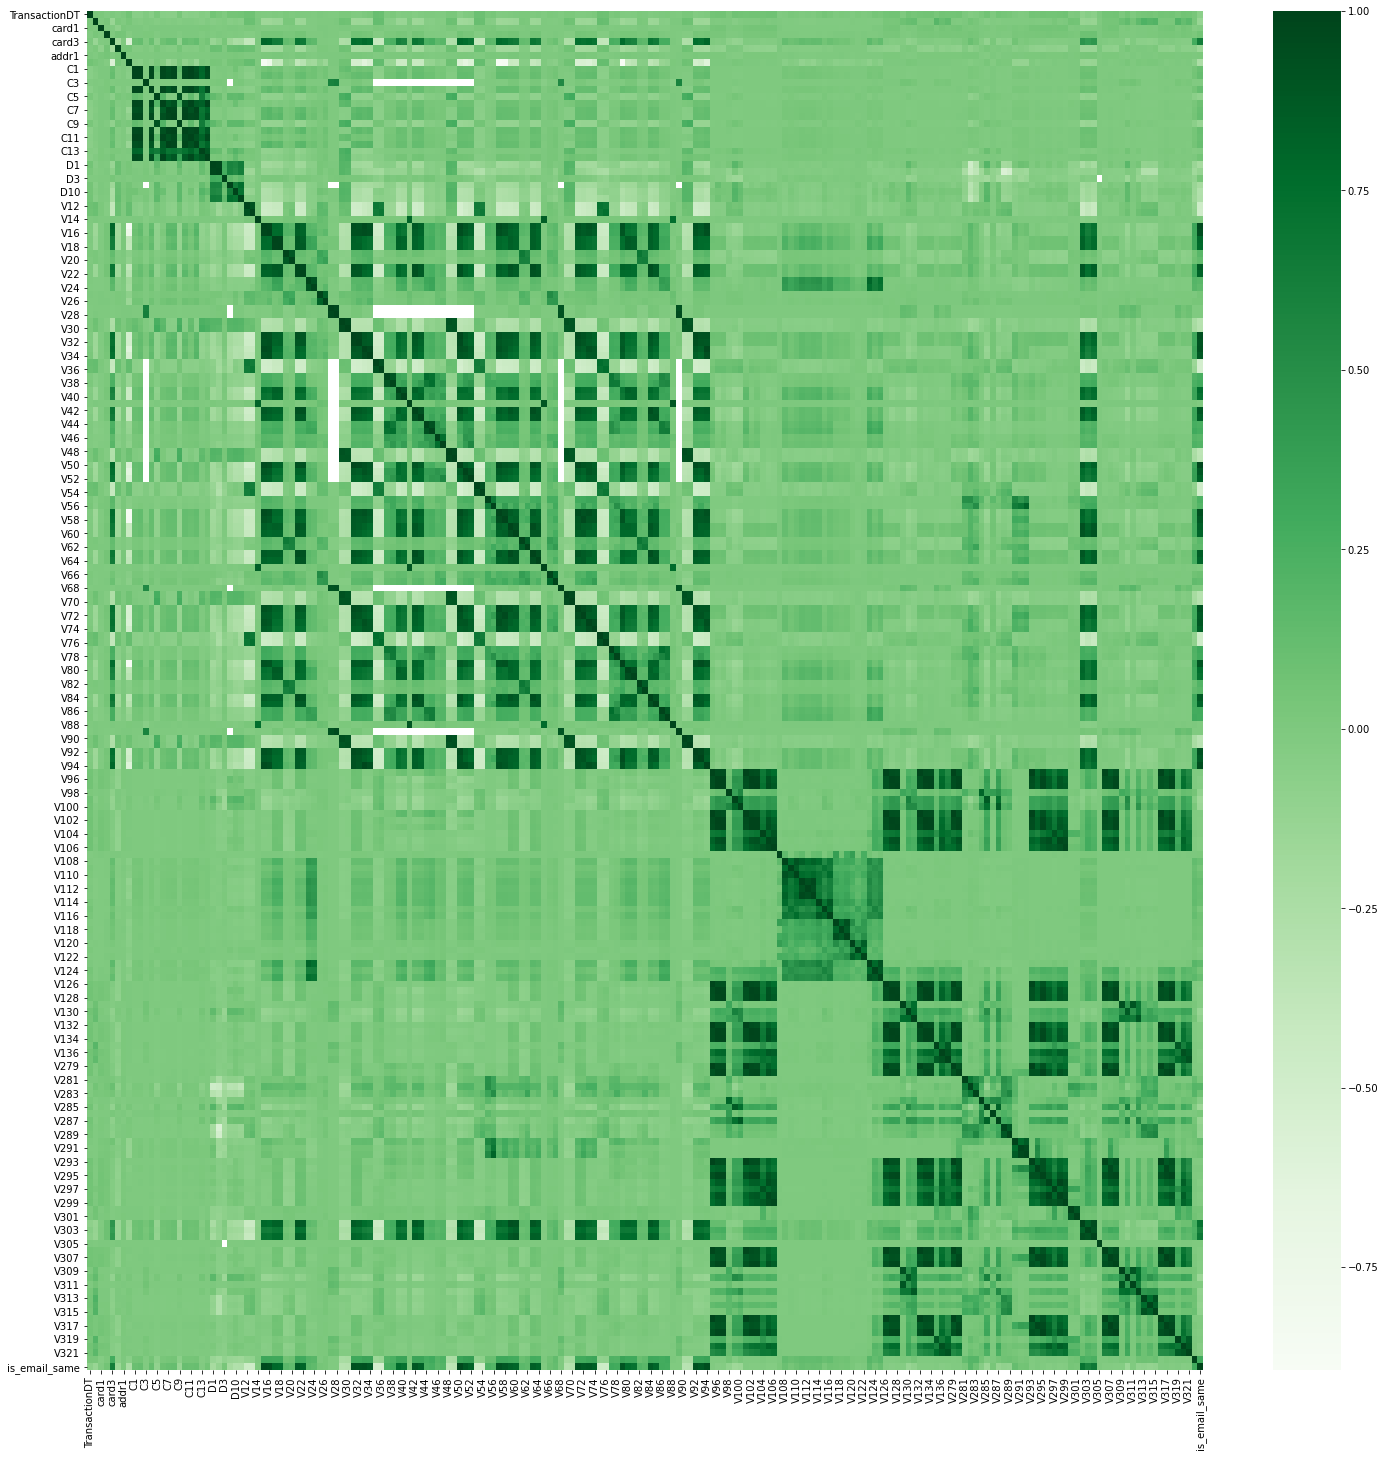

In [34]:
corrMatrix = train.corr()
fig, ax = plt.subplots(figsize=(25,25))    
sns.heatmap(corrMatrix, annot=False, cmap="Greens")
plt.show()

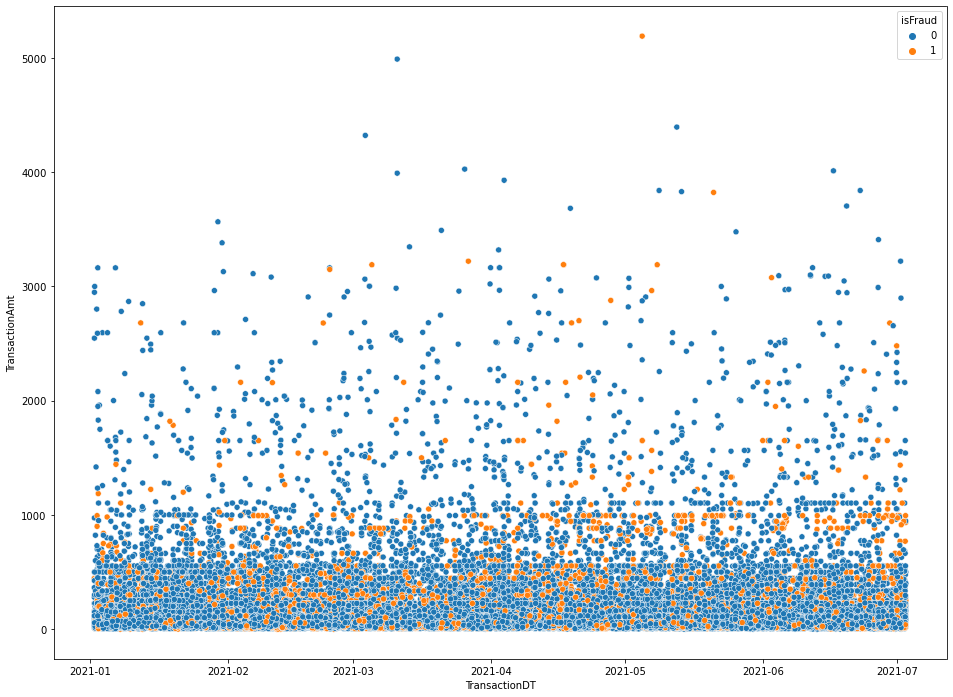

In [35]:
timeseries = train["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x))
timeseries
fig, ax = plt.subplots()

sns.scatterplot(x=timeseries, y="TransactionAmt", hue='isFraud', data=train) 
plt.show()

# ax.scatter(data=gdf, x=train["TransactionAmt"])
# # ax.scatter(timeseries, train["TransactionAmt"], label='TransactionAmt', s=10)
# ax.set_xlabel('Time')
# ax.set_ylabel('TransactionAmt')
# ax.legend()
# plt.show()

# remove outliers and fill missing

In [33]:
print(train.shape)
train = train[train.loc[:,'TransactionAmt'] < 4000]
print(train.shape)

(80884, 230)
(80871, 230)


In [37]:
percent_missing = train.isna().sum() / len(train)
percent_missing.sort_values(ascending=False)[:40]

D2     0.494523
D3     0.456787
V45    0.287754
V35    0.287754
V52    0.287754
V51    0.287754
V50    0.287754
V49    0.287754
V48    0.287754
V47    0.287754
V36    0.287754
V44    0.287754
V43    0.287754
V42    0.287754
V41    0.287754
V40    0.287754
V39    0.287754
V38    0.287754
V37    0.287754
V46    0.287754
D4     0.287693
V75    0.159252
V85    0.159252
V89    0.159252
V83    0.159252
V86    0.159252
V87    0.159252
V82    0.159252
V81    0.159252
V88    0.159252
V80    0.159252
V90    0.159252
V79    0.159252
V91    0.159252
V78    0.159252
V77    0.159252
V76    0.159252
V92    0.159252
V93    0.159252
V94    0.159252
dtype: float64

In [34]:
train_hot_categories = {}
def onehot(df, col, categories=None):
    print("using", col, categories)
    print("unique values:", df[col].unique().tolist())
    if categories:
        enc = OneHotEncoder(sparse=False, categories=(categories,), handle_unknown="ignore")
    else:
        enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
    array_hot_encoded = enc.fit_transform(df[[col]])
    print("get_feature_names:", enc.get_feature_names([col]))
    print("categories_:", enc.categories_)
    train_hot_categories[col] = list(enc.categories_[0])
    hot_array = pd.DataFrame(array_hot_encoded, columns=enc.get_feature_names([col]))
    print("hot_array.columns", hot_array.columns)
    return pd.concat([df.drop(columns=[col]).reset_index(drop=True), hot_array], axis=1)

In [35]:
num_cols_mask = (train.dtypes != object) & (train.columns != 'isFraud') & (train.nunique()>2)
not_num_cols_mask = (train.dtypes == object)
num_cols = train.columns[num_cols_mask]
print("num_cols", num_cols)
not_num_cols = train.columns[not_num_cols_mask]
print("not_num_cols", not_num_cols)

imp = SimpleImputer(strategy='constant', fill_value='missing')
imp.fit(train[not_num_cols])
train[not_num_cols] = imp.transform(train[not_num_cols])

train.reset_index(inplace=True)
for col in not_num_cols:
    train = onehot(df=train, col=str(col), categories=None)

train = train.drop(columns=[x for x in train.columns if x.endswith("_F")])

scaler = StandardScaler()
# scaler = RobustScaler(quantile_range=(25, 75))
train[num_cols] = scaler.fit_transform(train[num_cols])

# drop_more_than_N_Nan(15)

# nan_cols = train.columns[(train.isna().any())  & (train.nunique() != 2) & ((train.isna().sum() / len(train)) < 0.40)]
nan_cols = train.columns[(train.isna().any())  & (train.nunique() != 2)]
print("missing:", dict(train[nan_cols].isna().mean()))
print("KNNImputer cols:", nan_cols)
# done in chunks cause or else be here all day
# for i in range(0, len(nan_cols), 3):
#     chunk = nan_cols[i:i+3]
#     print(chunk)
#     imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=5)
#     imp_kNN.fit(train[chunk])
#     train[chunk] = imp_kNN.transform(train[chunk])
#     print(train.shape)
# imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=5)
# imp_kNN.fit(train[nan_cols])
# train[nan_cols] = imp_kNN.transform(train[nan_cols])
# print(train.shape)

imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(train[train.columns[train.isna().any()]])
train[train.columns[train.isna().any()]] = imp.transform(train[train.columns[train.isna().any()]])

# imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=3)
# imp_kNN.fit(train[nan_cols])
# train[nan_cols] = imp_kNN.transform(train[nan_cols])
# print(train.shape)
        
        
# nan_cols = train.columns[(train.isna().any())  & (train.nunique() == 2) | ((train.isna().sum() / len(train)) > 0.40) ]
# print("SimpleImputer cols:", nan_cols)
# imp = SimpleImputer(missing_values=np.nan, strategy='median')
# imp.fit(train[nan_cols])
# train[nan_cols] = imp.transform(train[nan_cols])

train.set_index("TransactionID", inplace=True)
# train.drop(columns="index", inplace=True)

num_cols Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'C1', 'C2',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=190)
not_num_cols Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       'TransactionDAYOFWEEK'],
      dtype='object')
using ProductCD None
unique values: ['W', 'C', 'H', 'S', 'R']
get_feature_names: ['ProductCD_C' 'ProductCD_H' 'ProductCD_R' 'ProductCD_S' 'ProductCD_W']
categories_: [array(['C', 'H', 'R', 'S', 'W'], dtype=object)]
hot_array.columns Index(['ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W'],
      dtype='object')
using card4 No

using id_31 None
unique values: ['missing', 'safari', 'chrome', 'ie', 'android', 'firefox', 'opera', 'edge', 'samsung', 'other', 'icedragon']
get_feature_names: ['id_31_android' 'id_31_chrome' 'id_31_edge' 'id_31_firefox'
 'id_31_icedragon' 'id_31_ie' 'id_31_missing' 'id_31_opera' 'id_31_other'
 'id_31_safari' 'id_31_samsung']
categories_: [array(['android', 'chrome', 'edge', 'firefox', 'icedragon', 'ie',
       'missing', 'opera', 'other', 'safari', 'samsung'], dtype=object)]
hot_array.columns Index(['id_31_android', 'id_31_chrome', 'id_31_edge', 'id_31_firefox',
       'id_31_icedragon', 'id_31_ie', 'id_31_missing', 'id_31_opera',
       'id_31_other', 'id_31_safari', 'id_31_samsung'],
      dtype='object')
using id_33 None
unique values: ['missing', '2208x1242', '1920x1080', 'other', '1366x768']
get_feature_names: ['id_33_1366x768' 'id_33_1920x1080' 'id_33_2208x1242' 'id_33_missing'
 'id_33_other']
categories_: [array(['1366x768', '1920x1080', '2208x1242', 'missing', 'other'],
     

In [39]:
print(train.sample(5).T.to_string())

TransactionID                    3246806   3195262   3468862   3368279   3088842
TransactionDT                  -0.254004 -0.558722  1.107128  0.466113 -1.155411
TransactionAmt                 -0.400279 -0.418709 -0.466667  -0.35767 -0.344931
card1                          -0.227053  1.302883  0.712328  -0.44716  1.227406
card2                           0.868859  0.677879  -0.59532  0.945251  1.155329
card3                           2.366311 -0.358885 -0.358885 -0.358885  2.366311
card5                           0.616833  -1.46353 -0.770076  0.664658 -1.439618
addr1                           0.074586  0.379449  1.471052  2.169285  0.074586
addr2                           0.080432  0.080432  0.080432  0.080432  0.080432
C1                             -0.109003 -0.102614 -0.109003 -0.102614 -0.109003
C2                             -0.101748 -0.107157 -0.107157 -0.107157 -0.107157
C3                             -0.047012 -0.047012 -0.047012 -0.047012 -0.047012
C4                          

In [40]:
# train.to_pickle("train_FULL.pkl")
# train = pd.read_pickle("train_FULL.pkl")
print(train.shape)

(13332, 320)


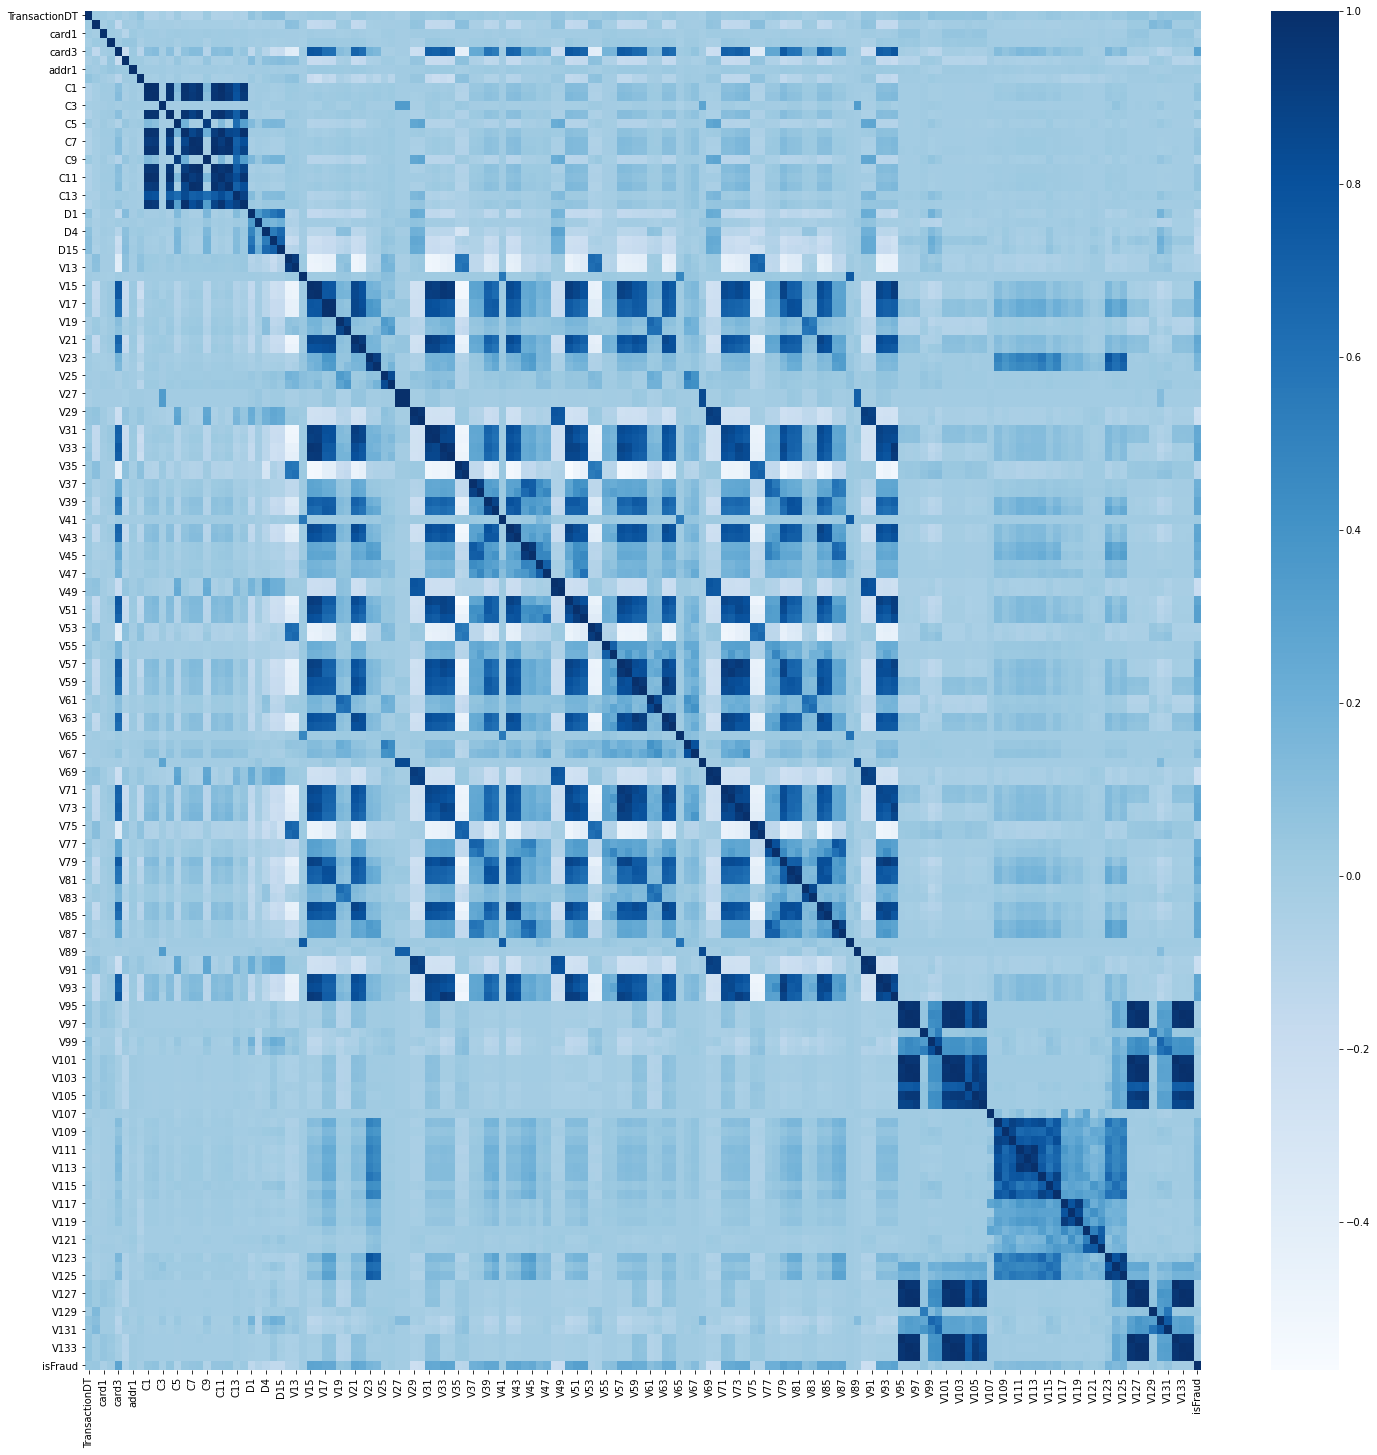

In [41]:
corrMatrix = train.loc[:,list(train.columns[:150]) +["isFraud"]].corr()
fig, ax = plt.subplots(figsize=(25,25))    
sns.heatmap(corrMatrix, annot=False, cmap="Blues")
plt.show()

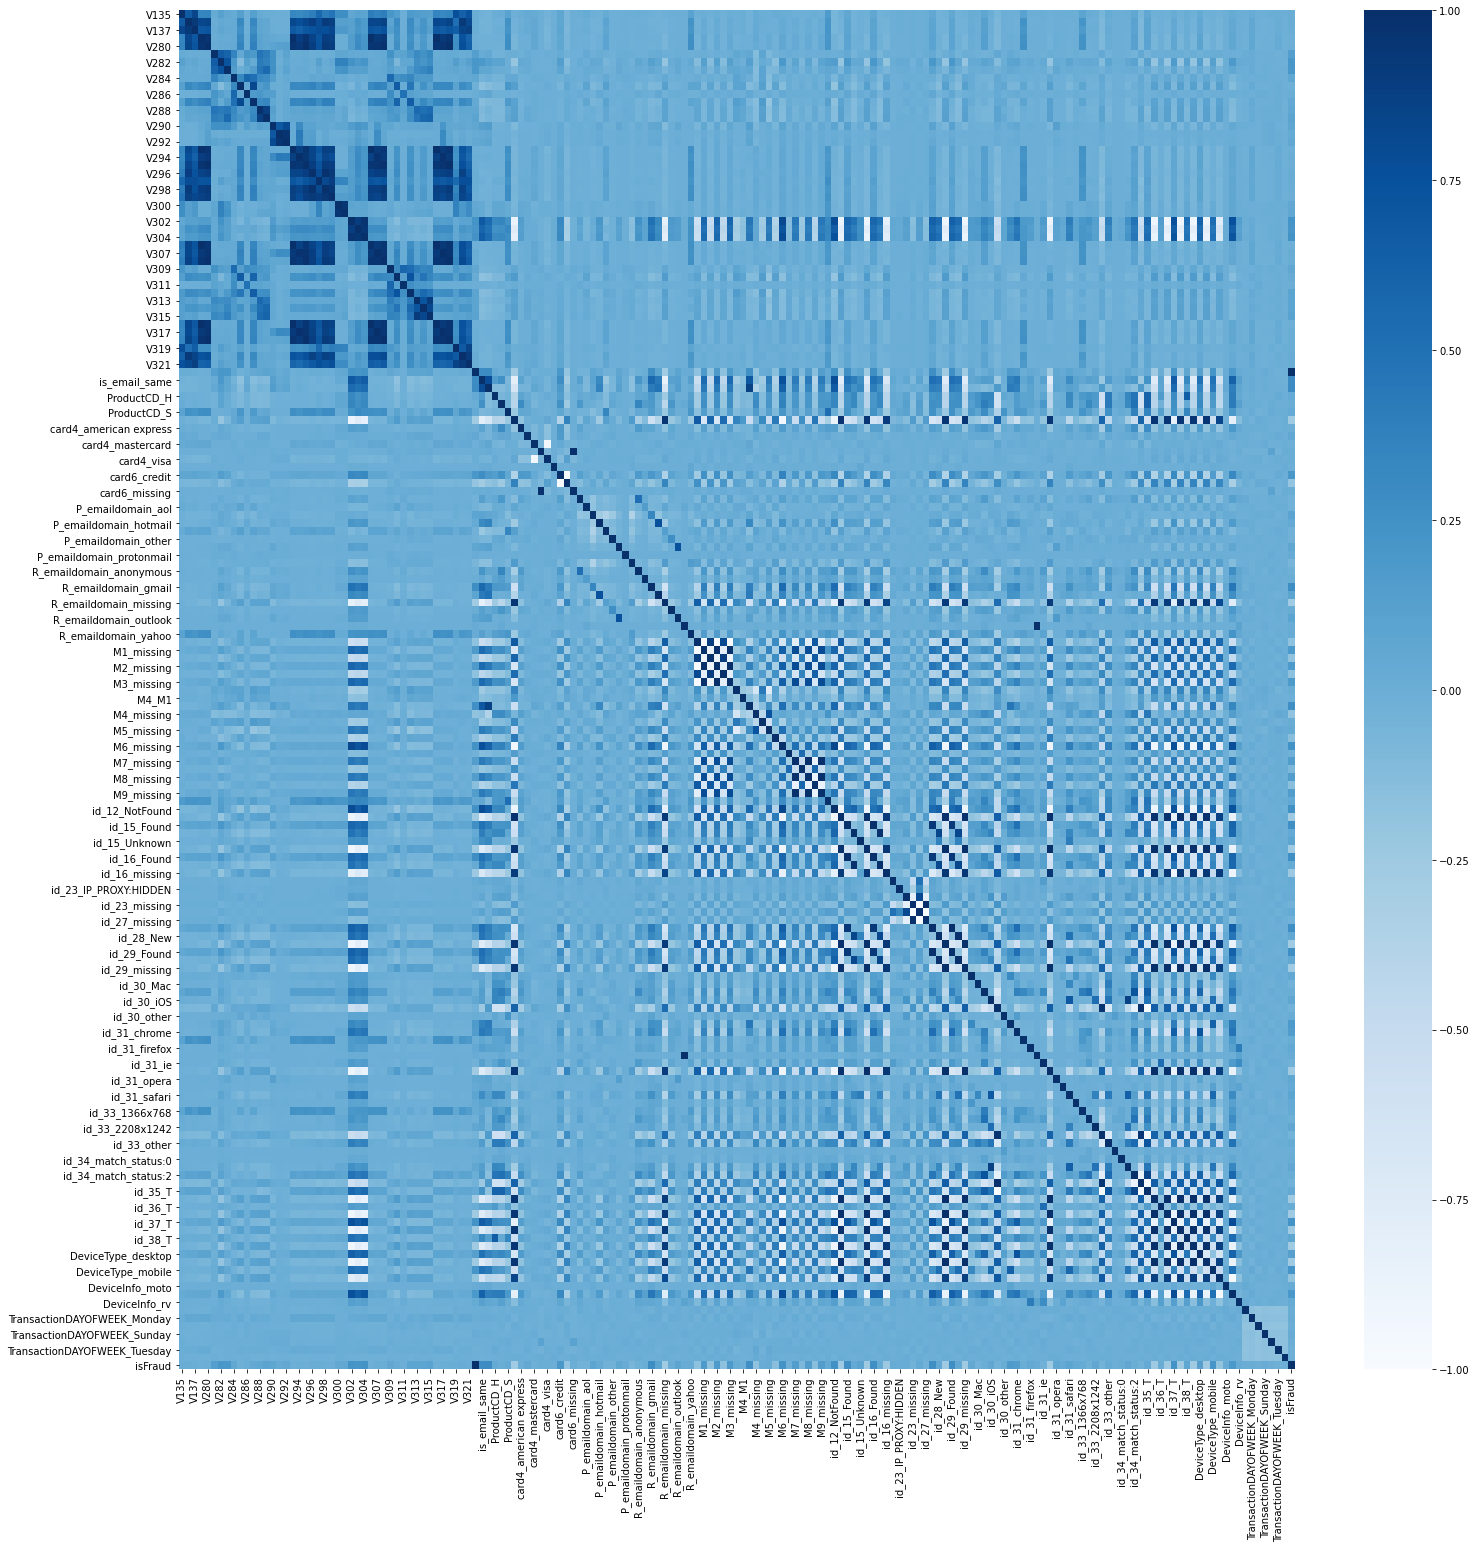

In [42]:
corrMatrix = train.loc[:,list(train.columns[150:]) +["isFraud"]].corr()
fig, ax = plt.subplots(figsize=(25,25))    
sns.heatmap(corrMatrix, annot=False, cmap="Blues")
plt.show()

# Select features

In [36]:
y_train = train['isFraud']
X_train = train.drop('isFraud', axis=1)

In [44]:
mi = dict()

i_scores = mutual_info_classif(X_train, y_train)

for i,j in zip(X_train.columns,i_scores):
    mi[i]=j
 
df = pd.DataFrame.from_dict(mi,orient='index',columns=['I-Gain'])
df.sort_values(by=['I-Gain'],ascending=False,inplace=True)
df.head(40)

,I-Gain
card1,0.086390
TransactionAmt,0.072129
card2,0.066168
C8,0.056428
C4,0.055945
C12,0.055375
C7,0.053860
C10,0.047291
V52,0.041883
V45,0.039292


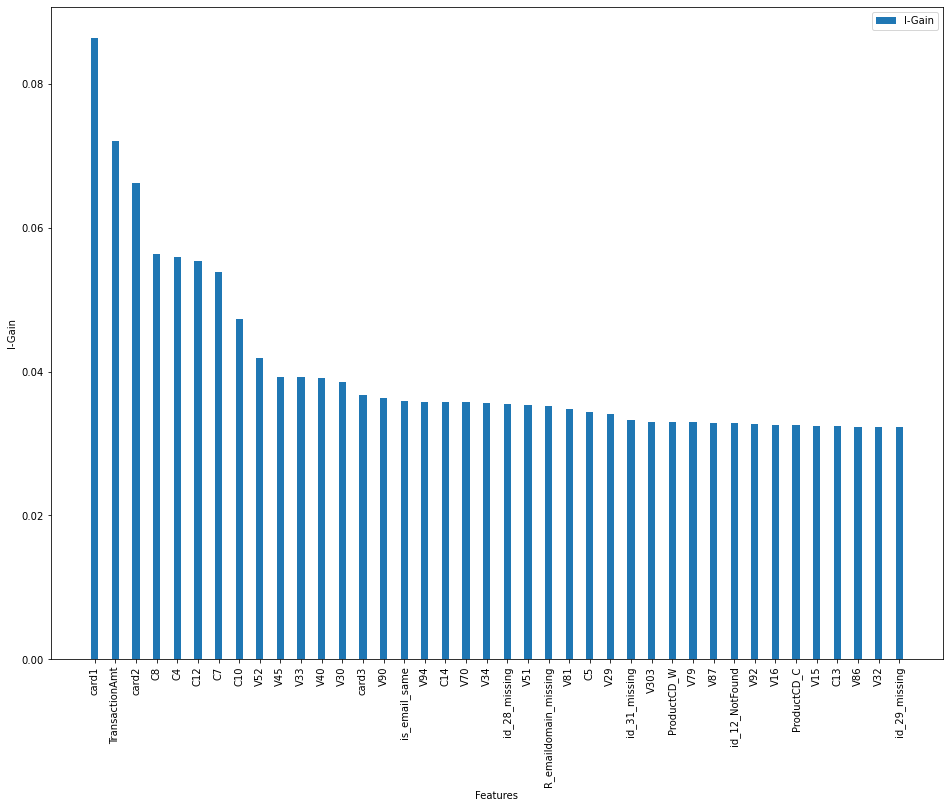

In [45]:
savedf = df
df = df[:40]

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)

ax.xaxis.set_major_locator(mticker.FixedLocator(range(0,n)))
ax.set_xticklabels(list(df.index), rotation = 90)

ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax.legend()

df = savedf

plt.show()


In [46]:
percent_missing = X_train.isna().sum() / len(X_train)
percent_missing.sort_values(ascending=False)[:40]

TransactionDT               0.0
P_emaildomain_anonymous     0.0
P_emaildomain_protonmail    0.0
P_emaildomain_outlook       0.0
P_emaildomain_other         0.0
P_emaildomain_missing       0.0
P_emaildomain_hotmail       0.0
P_emaildomain_gmail         0.0
P_emaildomain_aol           0.0
card6_missing               0.0
R_emaildomain_anonymous     0.0
card6_debit                 0.0
card6_credit                0.0
card6_charge card           0.0
card4_visa                  0.0
card4_missing               0.0
card4_mastercard            0.0
card4_discover              0.0
P_emaildomain_yahoo         0.0
R_emaildomain_aol           0.0
ProductCD_W                 0.0
M2_T                        0.0
M4_missing                  0.0
M4_M2                       0.0
M4_M1                       0.0
M4_M0                       0.0
M3_missing                  0.0
M3_T                        0.0
M2_missing                  0.0
M1_missing                  0.0
R_emaildomain_gmail         0.0
M1_T    

In [47]:
percent_missing = y_train.isna().sum() / len(y_train)
percent_missing

0.0

# Now fix my test to match train

In [37]:
def fix_test_set(test):
    # using the same start as train, so the days makes sense, they mightn't be the actual correct days but hey 
    test["TransactionDAYOFWEEK"] = test["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x)).dt.day_name()
    test.columns=test.columns.str.replace('-','_')
    print("dropping these:", columns_dropped)
    print(test.shape)
    test.drop(columns=columns_dropped, inplace=True)
    print(test.shape)
    
    imp = SimpleImputer(strategy='constant', fill_value='missing')
    imp.fit(test[test.columns[test.dtypes == object]])
    test[test.columns[test.dtypes == object]] = imp.transform(test[test.columns[test.dtypes == object]])

    
    test['is_email_same'] = test.apply(lambda x: x['P_emaildomain']== x['R_emaildomain'] and x['R_emaildomain'] != np.nan, axis=1)
    test.loc[test['P_emaildomain'].isna(), 'P_emaildomain'] = "missing"
    for i in email_repl:
        test.loc[test['P_emaildomain'].str.contains(i), 'P_emaildomain'] = i
    test.loc[~test['P_emaildomain'].isin(email_repl), 'P_emaildomain'] = "other"

    test.loc[test['R_emaildomain'].isna(), 'R_emaildomain'] = "missing"
    for i in email_repl:
        test.loc[test['R_emaildomain'].str.contains(i), 'R_emaildomain'] = i
    test.loc[~test['R_emaildomain'].isin(email_repl), 'R_emaildomain'] = "other"

    test.loc[test['id_31'].isna(), 'id_31'] = "missing"
    for i in id_31_repl:
        test.loc[test['id_31'].str.contains(i), 'id_31'] = i
    test.loc[~test['id_31'].isin(id_31_repl), 'id_31'] = "other"

    test.loc[test['id_30'].isna(), 'id_30'] = "missing"
    for i in id_30_repl:
        test.loc[test['id_30'].str.contains(i), 'id_30'] = i
    test.loc[~test['id_30'].isin(id_30_repl), 'id_30'] = "other"

    test.loc[test['id_33'].isna(), 'id_33'] = "missing"
    for i in id_33_repl:
        test.loc[test['id_33'].str.contains(i), 'id_33'] = i
    test.loc[~test['id_33'].isin(id_33_repl), 'id_33'] = "other"

    test.loc[test['DeviceInfo'].isna(), 'DeviceInfo'] = "missing"
    for i in DeviceInfo_repl:
        test.loc[test['DeviceInfo'].str.contains(i), 'DeviceInfo'] = i
    test.loc[~test['DeviceInfo'].isin(DeviceInfo_repl), 'DeviceInfo'] = "other"
    test['DeviceInfo'].value_counts().head(15)
#     test[["id_35","id_36","id_37","id_38"]] = test[["id_35","id_36","id_37","id_38"]].apply(convert_binary)
    
    imp = SimpleImputer(strategy='constant', fill_value='missing')
    imp.fit(test[not_num_cols])
    test[not_num_cols] = imp.transform(test[not_num_cols])
    
    test.reset_index(inplace=True)
    for col in not_num_cols:
        test = onehot(df=test, col=str(col), categories=train_hot_categories[col])
    
    scaler = StandardScaler()
#     scaler = RobustScaler(quantile_range=(25, 75))
    test[num_cols] = scaler.fit_transform(test[num_cols])
    

    # nan_cols = train.columns[(train.isna().any())  & (train.nunique() != 2) & ((train.isna().sum() / len(train)) < 0.40)]
    nan_cols = test.columns[(test.isna().any())  & (test.nunique() != 2)]
    print("missing:", dict(test[nan_cols].isna().mean()))
    print("KNNImputer cols:", nan_cols)
    # done in chunks cause or else be here all day
#     for i in range(0, len(nan_cols), 3):
#         chunk = nan_cols[i:i+3]
#         print(chunk)
#         imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=5)
#         imp_kNN.fit(test[chunk])
#         test[chunk] = imp_kNN.transform(test[chunk])
#         print(test.shape)
#     imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=5)
#     imp_kNN.fit(test[nan_cols])
#     test[nan_cols] = imp_kNN.transform(test[nan_cols])
#     print(test.shape)

    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(test[test.columns[test.isna().any()]])
    test[test.columns[test.isna().any()]] = imp.transform(test[test.columns[test.isna().any()]])

    test = test.drop(columns=[x for x in test.columns if x.endswith("_F")])
    test.set_index("TransactionID", inplace=True)
    test.drop(columns="index", inplace=True)
    
    return test


In [49]:
test = fix_test_set(test)
y_test = test['isFraud']
X_test = test.drop('isFraud', axis=1)

dropping these: ['id_24', 'id_25', 'id_21', 'id_22', 'id_26', 'id_07', 'id_08', 'dist2', 'id_18', 'D7', 'id_32', 'D13', 'D14', 'id_04', 'id_03', 'id_14', 'V138', 'V139', 'V148', 'V140', 'V141', 'V142', 'V146', 'V147', 'V149', 'V157', 'V153', 'V154', 'V155', 'V163', 'V156', 'V162', 'V158', 'V161', 'V160', 'V166', 'V164', 'V150', 'V159', 'V152', 'V143', 'V144', 'V145', 'V151', 'V165', 'V323', 'V329', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'V328', 'V327', 'V326', 'V325', 'V324', 'V322', 'V330', 'D12', 'D9', 'D8', 'id_09', 'id_10', 'D6', 'id_13', 'V219', 'V243', 'V237', 'V240', 'V241', 'V242', 'V247', 'V244', 'V246', 'V248', 'V249', 'V252', 'V236', 'V232', 'V233', 'V218', 'V231', 'V230', 'V229', 'V228', 'V226', 'V225', 'V224', 'V223', 'V254', 'V217', 'V253', 'V235', 'V269', 'V263', 'V274', 'V273', 'V277', 'V278', 'V268', 'V267', 'V266', 'V275', 'V264', 'V265', 'V262', 'V261', 'V260', 'V258', 'V257', 'V276', 'id_05', 'id_06', 'id_20', 'V207', 'V206', 'V205',

using id_31 ['android', 'chrome', 'edge', 'firefox', 'icedragon', 'ie', 'missing', 'opera', 'other', 'safari', 'samsung']
unique values: ['missing', 'safari', 'chrome', 'firefox', 'android', 'opera', 'edge', 'ie', 'other', 'samsung']
get_feature_names: ['id_31_android' 'id_31_chrome' 'id_31_edge' 'id_31_firefox'
 'id_31_icedragon' 'id_31_ie' 'id_31_missing' 'id_31_opera' 'id_31_other'
 'id_31_safari' 'id_31_samsung']
categories_: [array(['android', 'chrome', 'edge', 'firefox', 'icedragon', 'ie',
       'missing', 'opera', 'other', 'safari', 'samsung'], dtype=object)]
hot_array.columns Index(['id_31_android', 'id_31_chrome', 'id_31_edge', 'id_31_firefox',
       'id_31_icedragon', 'id_31_ie', 'id_31_missing', 'id_31_opera',
       'id_31_other', 'id_31_safari', 'id_31_samsung'],
      dtype='object')
using id_33 ['1366x768', '1920x1080', '2208x1242', 'missing', 'other']
unique values: ['missing', 'other', '2208x1242', '1366x768', '1920x1080']
get_feature_names: ['id_33_1366x768' 'id_33_

In [50]:
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("y_train.value_counts: ",y_train.value_counts())
print("y_test.value_counts: ",y_test.value_counts())

X_train shape:  (13332, 319)
X_test shape:  (6667, 319)
y_train.value_counts:  0    11091
1     2241
Name: isFraud, dtype: int64
y_test.value_counts:  0    5518
1    1149
Name: isFraud, dtype: int64


In [51]:
c = KNeighborsClassifier(n_neighbors=3) 
# c = MLPClassifier(max_iter=2000, random_state=2,
#                     hidden_layer_sizes=[20])
# c = SVC(kernel = 'linear',C=0.1, probability=True) 

acc_scores = []
roc_scores = []
amount_features = 35
print("shape:", train.shape[1], "using", amount_features)
for kk in range(1, amount_features):
    print(kk)
    FS_trans = SelectKBest(mutual_info_classif, 
                           k=kk).fit(X_train, y_train)
    X_tR_new = FS_trans.transform(X_train)
    X_tS_new = FS_trans.transform(X_test)
    Fraud_NB = c.fit(X_tR_new, y_train)
    y_dash = Fraud_NB.predict(X_tS_new)
    acc = accuracy_score(y_test, y_dash)
    roc = roc_auc_score(y_test, y_dash)
    print(kk,acc, roc)
    acc_scores.append(acc)
    roc_scores.append(roc)


shape: 320 using 35
1
1 0.7859607019649018 0.51271004523214
2
2 0.7859607019649018 0.5499212798623131
3
3 0.8051597420128993 0.5994200166493643
4
4 0.8182090895455227 0.6197070525735697
5
5 0.8254087295635218 0.6264682938123859
6
6 0.8261586920653967 0.6265768080474661
7
7 0.8269086545672716 0.6290971615641318
8
8 0.8266086695665217 0.63063867882657
9
9 0.8275086245687716 0.6360060326343944
10
10 0.8365081745912705 0.6476446575192952
11
11 0.8434078296085196 0.6635274823341033
12
12 0.8324583770811459 0.6451981189183529
13
13 0.8407079646017699 0.6663755866945144
14
14 0.8417579121043948 0.6663207775423481
15
15 0.8407079646017699 0.6618964566001418
16
16 0.839958002099895 0.6686789117410195
17
17 0.8434078296085196 0.6752421302732319
18
18 0.8428078596070196 0.669022356140565
19
19 0.8372581370931453 0.6701488222262388
20
20 0.8452077396130193 0.681842256263306
21
21 0.8303584820758962 0.6601233213809952
22
22 0.8491075446227688 0.6879882154802496
23
23 0.8450577471126444 0.6810625467

In [52]:
df = df.iloc[:amount_features-1]
df['Accuracy'] = acc_scores
df['ROC AUC Score'] = roc_scores
df.head(20)

<ipython-input-52-2438f382be8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accuracy'] = acc_scores
<ipython-input-52-2438f382be8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROC AUC Score'] = roc_scores


,I-Gain,Accuracy,ROC AUC Score
card1,0.086390,0.785961,0.512710
TransactionAmt,0.072129,0.785961,0.549921
card2,0.066168,0.805160,0.599420
C8,0.056428,0.818209,0.619707
C4,0.055945,0.825409,0.626468
C12,0.055375,0.826159,0.626577
C7,0.053860,0.826909,0.629097
C10,0.047291,0.826609,0.630639
V52,0.041883,0.827509,0.636006
V45,0.039292,0.836508,0.647645


In [53]:
igain_20 = df.index[:20]
igain_20

Index(['card1', 'TransactionAmt', 'card2', 'C8', 'C4', 'C12', 'C7', 'C10',
       'V52', 'V45', 'V33', 'V40', 'V30', 'card3', 'V90', 'is_email_same',
       'V94', 'C14', 'V70', 'V34'],
      dtype='object')

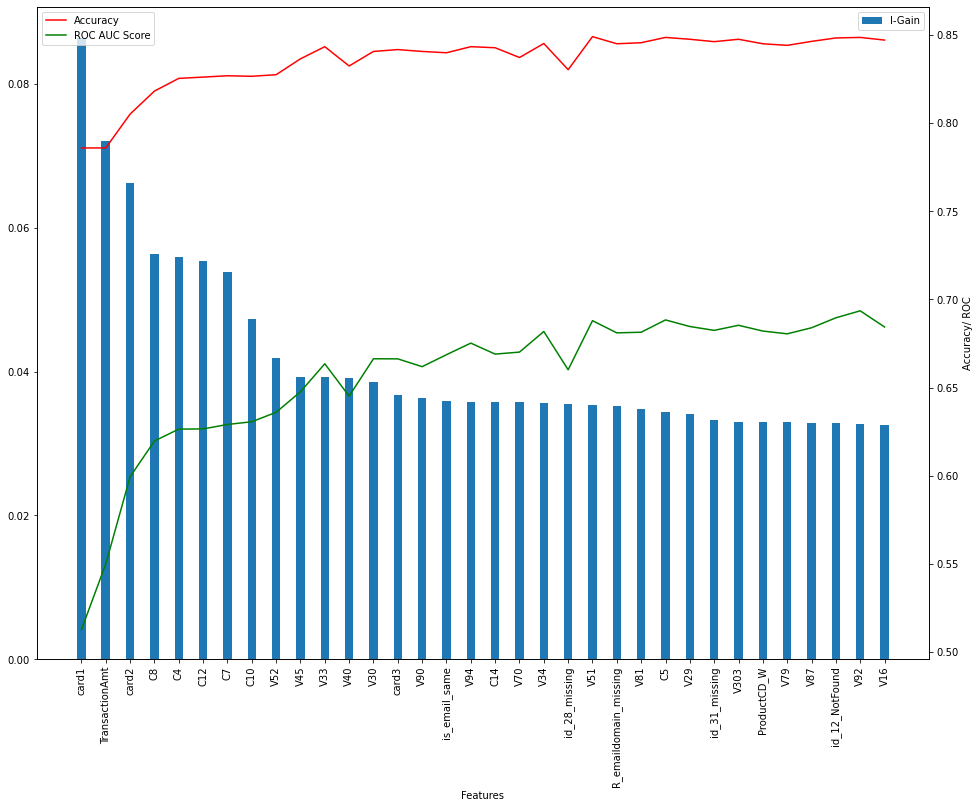

In [54]:
n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df.index, df["Accuracy"], color='red', label='Accuracy')
ax2.plot(df.index, df["ROC AUC Score"], color='green', label='ROC AUC Score')

ax.xaxis.set_major_locator(mticker.FixedLocator(range(0,n)))

ax.set_xticklabels(list(df.index), rotation = 90)

ax.set_xlabel('Features')
# ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy/ ROC')
ax.legend()
ax2.legend()
plt.show()

# trying feature selction with SequentialFeatureSelector

In [57]:
feature_names = X_train.columns
print(list(feature_names))

['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D3', 'D4', 'D10', 'D15', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:  1.6min finished
Features: 1/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:   23.9s finished
Features: 2/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 317 out of 317 | elapsed:   39.6s finished
Features: 3/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parall

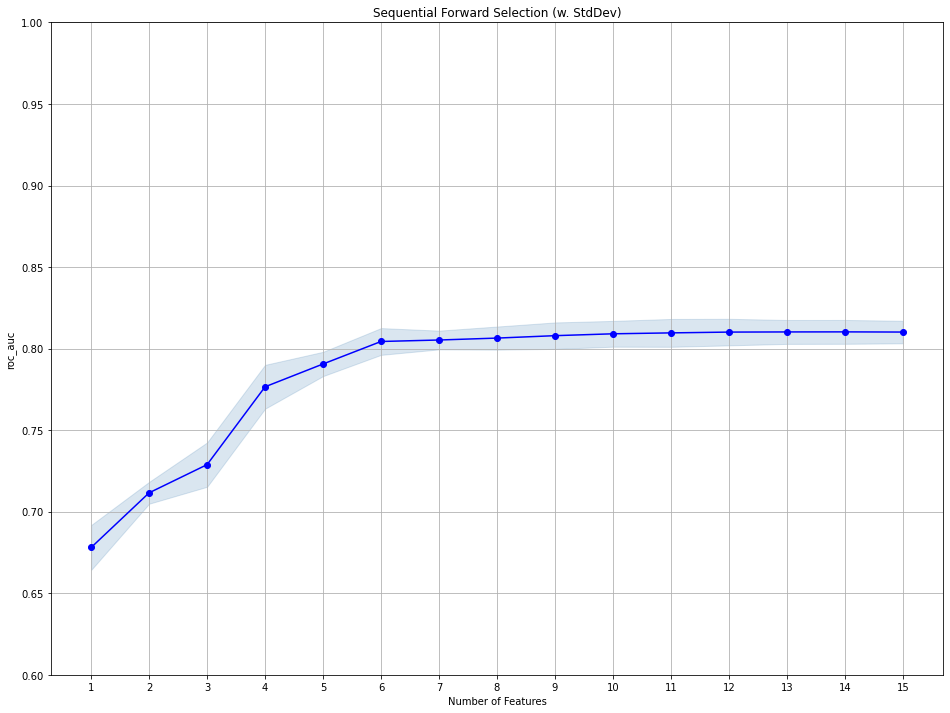

('card1', 'C1', 'C2', 'C5', 'C7', 'C14', 'V69', 'V90', 'V91', 'V281', 'ProductCD_W', 'card4_discover', 'P_emaildomain_protonmail', 'id_31_ie', 'id_31_other')


In [58]:
sfs_forward = SequentialFeatureSelector(
                KNeighborsClassifier(n_neighbors=3),
                k_features=15,
                forward=True,
                floating=False,
                verbose=1,
                scoring='roc_auc',
                cv=5,
                n_jobs=-1,
                pre_dispatch='2*n_jobs',
                clone_estimator=True,
                fixed_features=None,
            )

sfs_forward = sfs_forward.fit(X_train, y_train, 
                              custom_feature_names=feature_names)
from mlxtend.plotting import plot_sequential_feature_selection

fig1 = plot_sequential_feature_selection(sfs_forward.get_metric_dict(), 
                ylabel='roc_auc',
                kind='std_dev')

plt.ylim([0.6, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

# Trying Lasso feature selection

In [59]:
lr_selector = SelectFromModel(LogisticRegression(penalty="l1", 
                     C=.01, solver="liblinear"), max_features=X_train.shape[1])
lr_selector.fit(X_train, y_train)

X = pd.DataFrame(X_train)
lr_support = lr_selector.get_support()
lr_feature = X.loc[:,lr_support].columns.tolist()
print(str(len(lr_feature)), 'selected features')  
print('Selected features:')
lr_feature

52 selected features
Selected features:


['TransactionDT',
 'TransactionAmt',
 'card1',
 'card3',
 'C2',
 'C3',
 'D3',
 'D15',
 'V13',
 'V29',
 'V45',
 'V47',
 'V48',
 'V54',
 'V55',
 'V69',
 'V86',
 'V87',
 'V98',
 'V107',
 'V115',
 'V119',
 'V122',
 'V123',
 'V126',
 'V282',
 'V283',
 'V284',
 'V291',
 'V292',
 'V293',
 'V301',
 'V311',
 'V312',
 'V315',
 'card6_debit',
 'R_emaildomain_gmail',
 'R_emaildomain_missing',
 'M2_T',
 'M3_T',
 'M4_missing',
 'M5_missing',
 'M6_T',
 'id_15_missing',
 'id_16_missing',
 'id_23_missing',
 'id_27_missing',
 'id_28_missing',
 'id_29_missing',
 'id_37_missing',
 'id_38_missing',
 'DeviceType_missing']

# Compare models and evaluate

In [60]:
feature_names_dict = {"ALL": X_train.columns, 
                      "SFS":list(sfs_forward.k_feature_names_),
                      "LASSO": list(lr_feature),
                      "IGAIN_20": list(igain_20)}


In [61]:
lreg = LogisticRegression(solver='liblinear')
kNN = KNeighborsClassifier(n_neighbors=3)  
dtree = DecisionTreeClassifier(criterion='entropy')
svm = SVC(kernel = 'linear',C=1, probability=True)  
mlp1 = MLPClassifier(max_iter=2000, random_state=2,
                    hidden_layer_sizes=[20])
mlp2 = MLPClassifier(solver='lbfgs',random_state=0, max_iter=100)
models = [lreg,kNN,dtree,svm,mlp1,mlp2]  

ROC Analysis
ALL     LogisticRegression     Accuracy:0.8743		ROC:0.6936		ROC_AUC PROB:0.839	<LogisticRegression(solver='liblinear')>
ALL     KNeighborsClassifier   Accuracy:0.8698		ROC:0.7091		ROC_AUC PROB:0.7791	<KNeighborsClassifier(n_neighbors=3)>
ALL     DecisionTreeClassifier Accuracy:0.8421		ROC:0.7289		ROC_AUC PROB:0.7289	<DecisionTreeClassifier(criterion='entropy')>
ALL     SVC                    Accuracy:0.8724		ROC:0.6455		ROC_AUC PROB:0.8137	<SVC(C=1, kernel='linear', probability=True)>
ALL     MLPClassifier          Accuracy:0.8572		ROC:0.7377		ROC_AUC PROB:0.8195	<MLPClassifier(hidden_layer_sizes=[20], max_iter=2000, random_state=2)>


/home/kent/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ALL     MLPClassifier          Accuracy:0.8776		ROC:0.7555		ROC_AUC PROB:0.838	<MLPClassifier(max_iter=100, random_state=0, solver='lbfgs')>
SFS     LogisticRegression     Accuracy:0.8376		ROC:0.5425		ROC_AUC PROB:0.764	<LogisticRegression(solver='liblinear')>
SFS     KNeighborsClassifier   Accuracy:0.8536		ROC:0.7097		ROC_AUC PROB:0.7667	<KNeighborsClassifier(n_neighbors=3)>
SFS     DecisionTreeClassifier Accuracy:0.8376		ROC:0.7072		ROC_AUC PROB:0.7094	<DecisionTreeClassifier(criterion='entropy')>
SFS     SVC                    Accuracy:0.8365		ROC:0.5277		ROC_AUC PROB:0.7787	<SVC(C=1, kernel='linear', probability=True)>
SFS     MLPClassifier          Accuracy:0.8764		ROC:0.6914		ROC_AUC PROB:0.8176	<MLPClassifier(hidden_layer_sizes=[20], max_iter=2000, random_state=2)>


/home/kent/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


SFS     MLPClassifier          Accuracy:0.8733		ROC:0.6757		ROC_AUC PROB:0.8151	<MLPClassifier(max_iter=100, random_state=0, solver='lbfgs')>
LASSO   LogisticRegression     Accuracy:0.8644		ROC:0.6459		ROC_AUC PROB:0.8189	<LogisticRegression(solver='liblinear')>
LASSO   KNeighborsClassifier   Accuracy:0.8556		ROC:0.6929		ROC_AUC PROB:0.7685	<KNeighborsClassifier(n_neighbors=3)>
LASSO   DecisionTreeClassifier Accuracy:0.8056		ROC:0.6924		ROC_AUC PROB:0.6924	<DecisionTreeClassifier(criterion='entropy')>
LASSO   SVC                    Accuracy:0.8541		ROC:0.5835		ROC_AUC PROB:0.8042	<SVC(C=1, kernel='linear', probability=True)>
LASSO   MLPClassifier          Accuracy:0.8709		ROC:0.697		ROC_AUC PROB:0.8427	<MLPClassifier(hidden_layer_sizes=[20], max_iter=2000, random_state=2)>


/home/kent/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


LASSO   MLPClassifier          Accuracy:0.8727		ROC:0.7101		ROC_AUC PROB:0.8234	<MLPClassifier(max_iter=100, random_state=0, solver='lbfgs')>
IGAIN   LogisticRegression     Accuracy:0.853		ROC:0.6008		ROC_AUC PROB:0.7633	<LogisticRegression(solver='liblinear')>
IGAIN   KNeighborsClassifier   Accuracy:0.8403		ROC:0.6744		ROC_AUC PROB:0.7417	<KNeighborsClassifier(n_neighbors=3)>
IGAIN   DecisionTreeClassifier Accuracy:0.8184		ROC:0.6939		ROC_AUC PROB:0.6966	<DecisionTreeClassifier(criterion='entropy')>
IGAIN   SVC                    Accuracy:0.8484		ROC:0.5649		ROC_AUC PROB:0.7217	<SVC(C=1, kernel='linear', probability=True)>
IGAIN   MLPClassifier          Accuracy:0.8625		ROC:0.6433		ROC_AUC PROB:0.7974	<MLPClassifier(hidden_layer_sizes=[20], max_iter=2000, random_state=2)>
IGAIN   MLPClassifier          Accuracy:0.8605		ROC:0.6397		ROC_AUC PROB:0.7948	<MLPClassifier(max_iter=100, random_state=0, solver='lbfgs')>


/home/kent/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


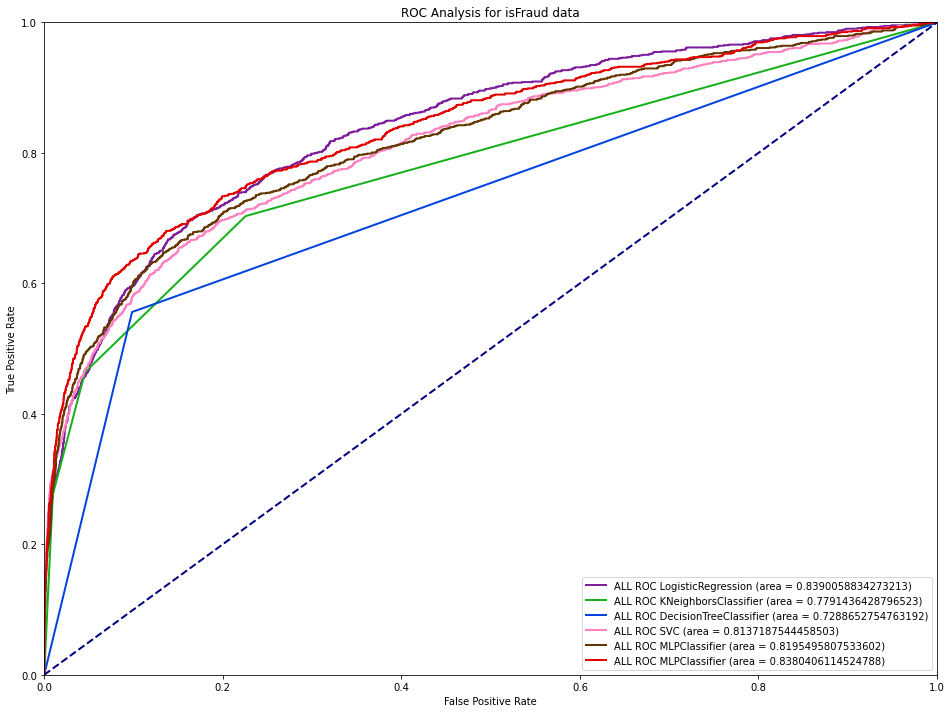

In [62]:
print('ROC Analysis')
plt.figure()
lw = 2
roc_results = []
best_score = 0
best_c = None
clist = list(mcolors.TABLEAU_COLORS) + list(mcolors.XKCD_COLORS)
for k, v in feature_names_dict.items():
    for m in models:
        m.fit(X_train[v], y_train)
        y_dash = m.predict(X_test[v])
        y_score = m.predict_proba(X_test[v])
        acc = accuracy_score(y_test, y_dash)
        roc = roc_auc_score(y_test, y_dash)
        details = str(m.get_params).replace("bound method BaseEstimator.get_params of ","")
        
        fprG, tprG, t = roc_curve(y_test, y_score[:,1])
        roc_aucG = auc(fprG, tprG)
        if k == "ALL":
            plt.plot(fprG, tprG, color=clist.pop(),
             lw=lw, label='{} ROC {} (area = {})'.format(k, type(m).__name__, roc_aucG))

        print("{:5.5}   {:22.22} Accuracy:{:4.4}\t\tROC:{:4.4}\t\tROC_AUC PROB:{:4.4}\t{}".format(k, type(m).__name__, acc, roc, roc_aucG, details))
        roc_results.append([k, type(m).__name__, acc, roc, details])
        if float(roc) > best_score:
            best_c = m 
            best_score = float(roc)
            


        
roc_results_df = pd.DataFrame(roc_results, columns = ['features','name','acc',"roc", "get_params"])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis for isFraud data')
plt.legend(loc="lower right")
plt.show()

In [63]:
roc_results_df.sort_values(["roc","acc"], ascending=False).reset_index(drop=True)

,features,name,acc,roc,get_params
0,ALL,MLPClassifier,0.877606,0.755509,"<MLPClassifier(max_iter=100, random_state=0, s..."
1,ALL,MLPClassifier,0.857207,0.737673,"<MLPClassifier(hidden_layer_sizes=[20], max_it..."
2,ALL,DecisionTreeClassifier,0.842058,0.728865,<DecisionTreeClassifier(criterion='entropy')>
3,LASSO,MLPClassifier,0.872656,0.710139,"<MLPClassifier(max_iter=100, random_state=0, s..."
4,SFS,KNeighborsClassifier,0.853607,0.709657,<KNeighborsClassifier(n_neighbors=3)>
5,ALL,KNeighborsClassifier,0.869807,0.709106,<KNeighborsClassifier(n_neighbors=3)>
6,SFS,DecisionTreeClassifier,0.837558,0.707197,<DecisionTreeClassifier(criterion='entropy')>
7,LASSO,MLPClassifier,0.870856,0.696992,"<MLPClassifier(hidden_layer_sizes=[20], max_it..."
8,IGAIN_20,DecisionTreeClassifier,0.818359,0.693876,<DecisionTreeClassifier(criterion='entropy')>
9,ALL,LogisticRegression,0.874306,0.693564,<LogisticRegression(solver='liblinear')>


In [64]:
print(best_c)

MLPClassifier(max_iter=100, random_state=0, solver='lbfgs')


In [38]:
best_c = MLPClassifier(max_iter=100, random_state=2,
                    hidden_layer_sizes=[10])

# take the full set to fit the best classifier 

In [39]:
# the full data needs to be taken again before executing here
best_c.fit(X_train, y_train)

/home/kent/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=[10], max_iter=100, random_state=2)

In [38]:
X_train.to_pickle("X_train.pkl")
y_train.to_pickle("y_train.pkl")

# Now for the Kaggle Test dataset

In [54]:
test_identity = pd.read_csv('data/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('data/ieee-fraud-detection/test_transaction.csv')

In [55]:
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
test.shape

(506691, 433)

In [56]:
del test_identity, test_transaction
gc.collect()
test.to_pickle("test.pkl")

In [39]:
test = pd.read_pickle("test.pkl")
# test = test.sample(n=1000)

### need to set value for the test set

In [40]:
test["isFraud"] = "test"

In [41]:
test.columns=test.columns.str.replace('-','_')

In [42]:
test = fix_test_set(test)


dropping these: ['id_24', 'id_25', 'id_26', 'id_21', 'id_22', 'id_08', 'id_07', 'dist2', 'id_18', 'D7', 'D13', 'id_32', 'D14', 'id_14', 'D12', 'id_03', 'id_04', 'V141', 'V142', 'V146', 'V139', 'V147', 'V138', 'V140', 'V149', 'V148', 'V155', 'V163', 'V162', 'V161', 'V158', 'V156', 'V157', 'V154', 'V153', 'V143', 'V144', 'V150', 'V145', 'V159', 'V160', 'V152', 'V164', 'V166', 'V151', 'V165', 'V323', 'V326', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'V325', 'V324', 'V322', 'V327', 'D6', 'D9', 'D8', 'id_09', 'id_10', 'id_13', 'V217', 'V232', 'V246', 'V244', 'V243', 'V241', 'V240', 'V237', 'V236', 'V235', 'V233', 'V231', 'V230', 'V229', 'V228', 'V226', 'V225', 'V224', 'V223', 'V219', 'V218', 'V248', 'V247', 'V242', 'V249', 'V252', 'V278', 'V277', 'V276', 'V275', 'V274', 'V273', 'V269', 'V268', 'V267', 'V266', 'V265', 'V264', 'V263', 'V262', 'V261', 'V260', 'V258', 'V257', 'V254', 'V253', 'id_05', 'id_06', 'id_20', 'id_19', 'id_17', 'V214

get_feature_names: ['id_23_IP_PROXY:ANONYMOUS' 'id_23_IP_PROXY:HIDDEN'
 'id_23_IP_PROXY:TRANSPARENT' 'id_23_missing']
categories_: [array(['IP_PROXY:ANONYMOUS', 'IP_PROXY:HIDDEN', 'IP_PROXY:TRANSPARENT',
       'missing'], dtype=object)]
hot_array.columns Index(['id_23_IP_PROXY:ANONYMOUS', 'id_23_IP_PROXY:HIDDEN',
       'id_23_IP_PROXY:TRANSPARENT', 'id_23_missing'],
      dtype='object')
using id_27 ['Found', 'missing']
unique values: ['missing', 'Found', 'NotFound']
get_feature_names: ['id_27_Found' 'id_27_missing']
categories_: [array(['Found', 'missing'], dtype=object)]
hot_array.columns Index(['id_27_Found', 'id_27_missing'], dtype='object')
using id_28 ['Found', 'New', 'missing']
unique values: ['missing', 'New', 'Found']
get_feature_names: ['id_28_Found' 'id_28_New' 'id_28_missing']
categories_: [array(['Found', 'New', 'missing'], dtype=object)]
hot_array.columns Index(['id_28_Found', 'id_28_New', 'id_28_missing'], dtype='object')
using id_29 ['Found', 'NotFound', 'missing']
un

In [43]:
test.to_pickle("test_ready.pkl")
# X_test.to_pickle("X_test.pkl")

In [ ]:
test_isFraud_prob = best_c.predict_proba(test.drop('isFraud', axis=1))
test_isFraud_prob[:,1][:10]

In [44]:
def package_for_kaggle(test_isFraud_prob):
    submission = pd.DataFrame({"TransactionID": test.index, "isFraud": test_isFraud_prob[:,1]}) 
    submission.to_csv("data/submission.csv", index=False)
    
package_for_kaggle(test_isFraud_prob)

In [ ]:
print(test.shape)